# Hybrid Movie Recommendation System

### About Dataset

Context
The datasets describe ratings and free-text tagging activities from MovieLens, a movie recommendation service. It contains 20000263 ratings and 465564 tag applications across 27278 movies. These data were created by 138493 users between January 09, 1995 and March 31, 2015. This dataset was generated on October 17, 2016.

Users were selected at random for inclusion. All selected users had rated at least 20 movies.

Content

No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in six files.


### tag.csv

It contains tags applied to movies by users:

userId ,movieId ,tag ,timestamp


### rating.csv

It contains ratings of movies by users:

userId ,movieId ,rating ,timestamp


### movie.csv

It contains movie information:

movieId ,title ,genres


### link.csv

It contains identifiers that can be used to link to other sources:

movieId ,imdbId ,tmbdId


### genome_scores.csv

It ontains movie-tag relevance data:

movieId ,tagId ,relevance



### genome_tags.csv

that contains tag descriptions:

tagId ,tag



# Importing Libraries

In [170]:
import joblib
import surprise
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise.model_selection import train_test_split
import gensim
from gensim.models import Word2Vec
from surprise import SVD, Dataset, Reader
import nltk
from nltk.corpus import stopwords

In [134]:
# movies = pd.read_csv('/content/movies.csv')  # Example file
# tags = pd.read_csv('/content/tags.csv')
# ratings = pd.read_csv('/content/ratings.csv')

In [135]:
# Defining the correct path to the Data directory (correct typo in folder name)
data_path = 'c:/Users/Hp/Desktop/streamlit_app_recomm/ml-latest-small/'

# Checking if the directory exists to avoid errors
if os.path.exists(data_path):
    # Loading datasets
    movies = pd.read_csv(os.path.join(data_path, 'movies.csv'))
    ratings = pd.read_csv(os.path.join(data_path, 'ratings.csv'))
    tags = pd.read_csv(os.path.join(data_path, 'tags.csv'))

    # Displaying the first few rows of each dataframe
    print("Movies DataFrame:")
    print(movies.head(), "\n")

    print('**************************************************************************')

    print("Ratings DataFrame:")
    print(ratings.head(), "\n")

    print('**************************************************************************')

    print("Tags DataFrame:")
    print(tags.head())

    print('**************************************************************************')
else:
    print(f"Data path does not exist: {data_path}")


Movies DataFrame:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy   

**************************************************************************
Ratings DataFrame:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931 

*************************************************************

# Data Cleaning and Preprocessing

In [136]:

# Checking for missing values
print('**************************************************************************')
print(movies.isnull().sum())
print('**************************************************************************')
print(ratings.isnull().sum())
print('**************************************************************************')
print(tags.isnull().sum())
print('**************************************************************************')

**************************************************************************
movieId    0
title      0
genres     0
dtype: int64
**************************************************************************
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
**************************************************************************
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64
**************************************************************************


In [137]:
# Dropping rows with missing values if necessary
movies.dropna(inplace=True)
ratings.dropna(inplace=True)
tags.dropna(inplace=True)

# Exploratory Data Analysis (EDA)

In [138]:
# Overview of movies
print(movies.info())
print('**************************************************************************')
print(movies.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 304.4+ KB
None
**************************************************************************
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                              

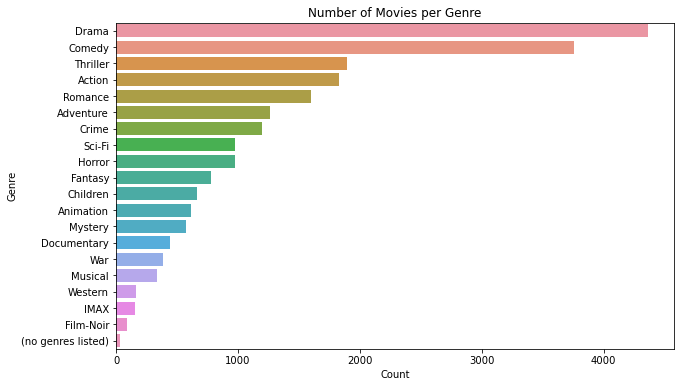

In [139]:
# Genre Distribution
movies['genres'] = movies['genres'].str.split('|')
all_genres = [genre for sublist in movies['genres'] for genre in sublist]
genre_freq = pd.Series(all_genres).value_counts()


plt.figure(figsize=(10, 6))
sns.barplot(x=genre_freq.values, y=genre_freq.index)
plt.title('Number of Movies per Genre')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

The bar plot above shows the distribution of movies across various genres, based on the number of movies associated with each genre. Here's a detailed breakdown:

Drama is the most frequent genre, with over 4,000 movies.

Comedy follows closely behind, with around 3,500 movies.

Other popular genres include Thriller, Action, Romance, and Adventure, all of which have around 2,000 to 3,000 movies.

Genres like Sci-Fi, Horror, Fantasy, and Children have a moderate presence, with between 1,000 to 2,000 movies.

Less frequent genres, such as Animation, Mystery, War, Musical, and Western, are represented by a few hundred to just over 1,000 movies.

Film-Noir and IMAX are the least common genres, with a very small number of movies listed.

A small number of movies have no genre listed.

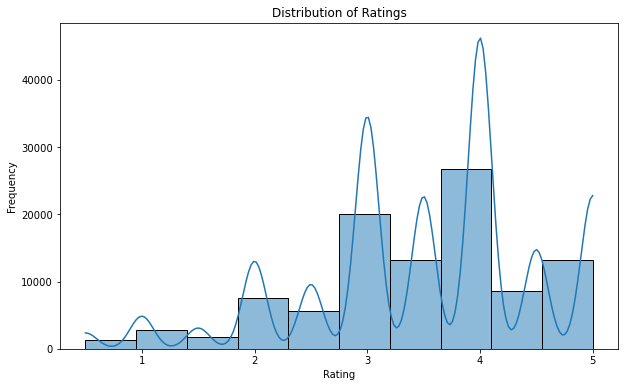

In [140]:
# Ratings Distribution
plt.figure(figsize=(10, 6))
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

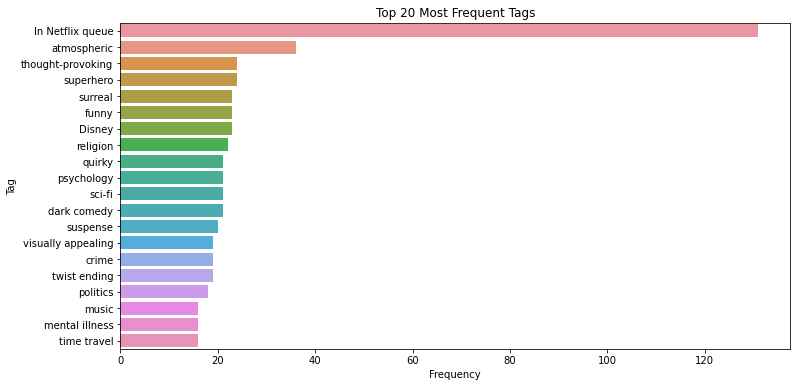

In [141]:
# Tag Analysis
top_tags = tags['tag'].value_counts().head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_tags.values, y=top_tags.index)
plt.title('Top 20 Most Frequent Tags')
plt.xlabel('Frequency')
plt.ylabel('Tag')
plt.show()

#  Content-Based Filtering Using NLP

### TF-IDF (Term Frequency-Inverse Document Frequency)

In [142]:
#Converting tags to lowercase
tags['tag'] = tags['tag'].str.lower()

#Grouping tags by movieId
tags_grouped = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()

#Creating the TF-IDF matrix while removing stopwords
tfidf = TfidfVectorizer(stop_words='english')  # Adding stopwords removal
tfidf_matrix = tfidf.fit_transform(tags_grouped['tag'])

### Word2Vec

In [143]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

#Converting tags to lowercase
tags['tag'] = tags['tag'].str.lower()

#Removing stopwords from the 'tag' column
tags['tag'] = tags['tag'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

#Grouping tags by userId and movieId and tokenizing them
tagged_data = tags.groupby(['userId', 'movieId'])['tag'].apply(lambda x: x.str.split()).reset_index()

#Training the Word2Vec model on the tokenized data
model = Word2Vec(tagged_data['tag'], vector_size=100, window=5, min_count=1, workers=4)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [163]:
def get_tag_vector(tag):
    """
    Given a tag (which might be a phrase), return the averaged Word2Vec vector for all words in the tag.
    If a word is not in the vocabulary, it is ignored.
    
    Args:
    - tag (str): A tag or phrase consisting of multiple words
    
    Returns:
    - numpy.ndarray: The averaged vector representation of the tag
    """
    words = tag.split()  # Tokenize the tag into individual words
    word_vectors = []

    for word in words:
        if word in model.wv:
            word_vectors.append(model.wv[word])
        else:
            print(f"Word '{word}' not in vocabulary.")

    # If no words from the tag exist in the vocabulary, return a zero vector
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)

    # Return the average of the vectors for words in the tag
    return np.mean(word_vectors, axis=0)


In [165]:
tag = "science "
tag_vector = get_tag_vector(tag)
print(tag_vector)


[-1.6850404e-03 -2.2208269e-03 -9.6157147e-03  9.4254110e-03
  4.4080766e-04  6.2190699e-03 -2.2281173e-03  2.2460879e-03
 -9.3329530e-03  5.3710444e-03 -6.0744290e-03  8.0729378e-03
  1.0004341e-02 -9.5659373e-03 -8.0332663e-03  3.6186904e-03
  8.4193889e-03  6.8864180e-03 -7.0057530e-03  9.7843166e-03
  1.5856344e-03  9.8318774e-03  3.7462814e-04 -8.7394370e-03
  6.5002763e-03 -7.9171462e-03 -7.2051687e-03 -1.7532415e-03
  2.2766322e-03 -8.9126453e-03 -1.1326385e-03  5.9798663e-03
 -7.6684952e-03 -9.3873693e-03 -4.0367614e-03  6.0613230e-03
 -3.4701370e-03 -1.6559511e-03 -3.7426769e-03 -8.8735754e-03
  5.9259506e-03 -8.6155097e-04 -9.1995671e-04  1.5301255e-03
 -2.0757227e-03 -7.8047267e-03 -8.2960539e-03 -4.9839946e-03
  7.6657049e-03 -6.4659765e-04  9.0268049e-03  6.3322410e-03
  4.8124101e-03  8.1822127e-03  7.9084476e-03 -3.3359698e-04
 -2.5385190e-03  2.8552900e-03  2.1103281e-03 -1.5901441e-03
  2.0834166e-03  2.8798946e-03  7.0577394e-03 -8.3693909e-03
 -1.3220948e-03  9.41635

### TF-IDF and Word2Vec Comparison

In [147]:
# Computing cosine similarity matrix tfidf
cosine_sim_tfidf = cosine_similarity(tfidf_matrix)

# Computing tag vectors and cosine similarity word2vec
tags_grouped['tag_vector'] = tags_grouped['tag'].apply(lambda x: get_tag_vector(x.split()))
cosine_sim_w2v = cosine_similarity(list(tags_grouped['tag_vector']))

Tag '['in', 'netflix', 'queue', 'jane', 'austen']' not in vocabulary.
Tag '['animal', 'movie', 'pigs', 'villain', 'nonexistent', 'or', 'not', 'needed', 'for', 'good', 'story']' not in vocabulary.
Tag '['chick', 'flick', 'funny', 'paul', 'rudd', 'quotable', 'seen', 'more', 'than', 'once', 'emma', 'jane', 'austen']' not in vocabulary.
Tag '['in', 'netflix', 'queue', 'south', 'africa']' not in vocabulary.
Tag '['jekyll', 'and', 'hyde']' not in vocabulary.
Tag '['in', 'netflix', 'queue']' not in vocabulary.
Tag '['made', 'me', 'cry']' not in vocabulary.
Tag '['school', 'adam', 'sandler', 'stop', 'looking', 'at', 'me', 'swan']' not in vocabulary.
Tag '['in', 'netflix', 'queue']' not in vocabulary.
Tag '['classic', 'space', 'action', 'action', 'sci-fi', 'epic', 'great', 'soundtrack', 'classic', 'sci-fi', 'engrossing', 'adventure', 'epic', 'classic', 'nerd', 'classic', 'sci-fi', 'space', 'action', 'space', 'epic', 'oldie', 'but', 'goodie', 'sci-fi', 'star', 'wars', 'robots', 'and', 'androids'

# Evaluation - Comparing TF-IDF and Word2Vec Approaches

In [169]:
def get_recommendations(movie_id, cosine_sim_matrix, top_n=10):
    """
    Get movie recommendations based on cosine similarity scores.

    This function retrieves the top N movies similar to the provided movie ID 
    using a cosine similarity matrix. The recommendations are sorted based on 
    their similarity scores in descending order.

    Parameters:
    - movie_id (int): The ID of the movie for which recommendations are sought.
    - cosine_sim_matrix (np.ndarray): A matrix containing cosine similarity scores
      for all movies.
    - top_n (int): The number of recommendations to return. Defaults to 10.

    Returns:
    - List[str]: A list of movie titles recommended based on the given movie ID.
    
    Raises:
    - ValueError: If the provided movie ID does not exist in the dataset.

    """
    
    # Check if the movie_id exists in the tags_grouped DataFrame
    if movie_id not in tags_grouped['movieId'].values:
        raise ValueError(f"Movie ID {movie_id} not found.")
    
    # Get the index of the movie in the DataFrame
    idx = tags_grouped.index[tags_grouped['movieId'] == movie_id][0]
    
    # Get similarity scores for the selected movie
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))
    
    # Sort the movies based on the similarity scores (highest first)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Extract the indices of the top-n most similar movies (excluding the first as it's the movie itself)
    movie_indices = [i[0] for i in sim_scores[1:top_n + 1]]
    
    # Return the movie titles instead of just movie IDs
    return movies['title'].iloc[movie_indices]

# Getting recommendations using both approaches for comparison
tfidf_recommendations = get_recommendations(1, cosine_sim_tfidf)
w2v_recommendations = get_recommendations(1, cosine_sim_w2v)
print('************************************************************')
print('************************************************************')
# Displaying the results
print("TF-IDF Recommendations:")
for movie in tfidf_recommendations:
    print(movie)
    
print('************************************************************')
print('************************************************************')
print("\nWord2Vec Recommendations:")
for movie in w2v_recommendations:
    print(movie)
print('************************************************************')
print('************************************************************')

************************************************************
************************************************************
TF-IDF Recommendations:
Nelly & Monsieur Arnaud (1995)
Supercop 2 (Project S) (Chao ji ji hua) (1993)
In Search of the Castaways (1962)
In the Heat of the Night (1967)
Cat from Outer Space, The (1978)
Last Temptation of Christ, The (1988)
Friday the 13th Part VII: The New Blood (1988)
White Squall (1996)
Jumanji (1995)
Grumpier Old Men (1995)
************************************************************
************************************************************

Word2Vec Recommendations:
Nelly & Monsieur Arnaud (1995)
Supercop 2 (Project S) (Chao ji ji hua) (1993)
In Search of the Castaways (1962)
Eve's Bayou (1997)
Amos & Andrew (1993)
Adventures of Robin Hood, The (1938)
Welcome to Sarajevo (1997)
Women, The (1939)
Love Bug, The (1969)
Devil and Max Devlin, The (1981)
************************************************************
***********************************

#  Collaborative Filtering

### Building a Collaborative Filtering Model

In [149]:


# Assuming `ratings` is a DataFrame with 'userId', 'movieId', and 'rating' columns
# Define the rating scale (minimum and maximum ratings)
reader = Reader(rating_scale=(0.5, 5.0))

# Load the data from the DataFrame into Surprise's format
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Split the dataset into training and testing sets (optional)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Initialize the SVD model
svd_model = SVD()

# Fit the model on the training set
svd_model.fit(trainset)

# Optionally, you can evaluate the model on the test set (not included in the original snippet)
# predictions = svd_model.test(testset)


### Predict Ratings

In [150]:
# Function to predict ratings for a specific user and movie
def predict_rating(user_id, movie_id):
    # Use the SVD model to predict the rating
    return svd_model.predict(user_id, movie_id).est

In [151]:
# Function to predict ratings for a given user and a list of movie IDs
def predict_ratings_for_movies(user_id, movie_ids):
    predicted_ratings = []

    # Predict ratings for each movie in the list
    for movie_id in movie_ids:
        predicted_rating = predict_rating(user_id, movie_id)  # Predicting rating for this user and movie
        predicted_ratings.append((movie_id, predicted_rating))

    return predicted_ratings

In [152]:
# Function to generate hybrid recommendations for a user based on a seed movie (content + collaborative filtering)
def hybrid_recommendation(user_id, movie_id, n=10):
    # Get content-based recommendations using TF-IDF (or could be Word2Vec)
    content_recommendations = get_recommendations(movie_id, cosine_sim_tfidf, top_n=n)

    # Predict ratings for the content-based recommendations using collaborative filtering (SVD model)
    predicted_ratings = predict_ratings_for_movies(user_id, content_recommendations)

    # Sort the predicted ratings in descending order
    predicted_ratings = sorted(predicted_ratings, key=lambda x: x[1], reverse=True)

    # Create a DataFrame to store the results
    results = []
    for movie_id, rating in predicted_ratings[:n]:
        # Get the movie title based on the movieId
        movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
        results.append({'Movie ID': movie_id, 'Movie Title': movie_title, 'Predicted Rating': rating})

    # Convert the results to a pandas DataFrame
    recommendations_df = pd.DataFrame(results)

    # Display the results vertically
    for index, row in recommendations_df.iterrows():
        print(f"\nRecommendation {index + 1}:")
        print(f"Movie ID: {row['Movie ID']}")
        print(f"Movie Title: {row['Movie Title']}")
        print(f"Predicted Rating: {row['Predicted Rating']:.2f}")

    return recommendations_df  # Optionally return the DataFrame



In [153]:
# usage of the hybrid recommendation function
user_id = 1  # Specify the user_id
movie_id = 2  # Specify the movie_id (seed movie)
n = 5  # Specify the number of recommendations

# Getting the top 'n' hybrid recommendations for the user
recommendations = hybrid_recommendation(user_id, movie_id, n)


Recommendation 1:
Movie ID: 1104
Movie Title: Streetcar Named Desire, A (1951)
Predicted Rating: 5.00

Recommendation 2:
Movie ID: 4993
Movie Title: Lord of the Rings: The Fellowship of the Ring, The (2001)
Predicted Rating: 4.92

Recommendation 3:
Movie ID: 971
Movie Title: Cat on a Hot Tin Roof (1958)
Predicted Rating: 4.53

Recommendation 4:
Movie ID: 46972
Movie Title: Night at the Museum (2006)
Predicted Rating: 4.37

Recommendation 5:
Movie ID: 184471
Movie Title: Tomb Raider (2018)
Predicted Rating: 4.11


##  Hybrid Recommendation Model

### Combining Content-Based and Collaborative Filtering

In [154]:
# Combining Content-Based and Collaborative Filtering
def hybrid_recommendation(user_id, movie_id, top_n=10):
    # Getting content-based recommendations
    content_recommendations = get_recommendations(movie_id, cosine_sim_tfidf)

    # Predicting ratings for content-based recommendations
    predicted_ratings = [(movie, predict_rating(user_id, movie)) for movie in content_recommendations]

    # Sorting the predicted ratings in descending order
    predicted_ratings = sorted(predicted_ratings, key=lambda x: x[1], reverse=True)

    # Extracting the top N movie IDs
    top_movie_ids = [movie for movie, rating in predicted_ratings[:top_n]]

    # Getting the movie names from the movies DataFrame
    top_movie_names = movies[movies['movieId'].isin(top_movie_ids)]['title'].tolist()

    return top_movie_names  # Returning movie names instead of IDs

In [155]:
hybrid_recommendation(1,2,8)

['Cat on a Hot Tin Roof (1958)',
 'Streetcar Named Desire, A (1951)',
 'Lord of the Rings: The Fellowship of the Ring, The (2001)',
 'Insomnia (2002)',
 'Harry Potter and the Chamber of Secrets (2002)',
 'Harry Potter and the Prisoner of Azkaban (2004)',
 'Harry Potter and the Goblet of Fire (2005)',
 'Night at the Museum (2006)']

In [156]:
def get_recommendations(movie_id, cosine_sim_matrix, top_n=10):
    # Get the index of the movie in the original DataFrame
    idx = tags_grouped.index[tags_grouped['movieId'] == movie_id].tolist()

    # Check if the movie_id is in the DataFrame
    if not idx:
        print(f"Movie ID {movie_id} not found.")
        return []

    idx = idx[0]  # Get the first index if there are multiple matches

    # Compute similarity scores and sort them
    sim_scores = sorted(enumerate(cosine_sim_matrix[idx]), key=lambda x: x[1], reverse=True)

    # Get the indices of the top N similar movies
    movie_indices = [i[0] for i in sim_scores[1:top_n + 1]]

    # Return movie IDs from the original DataFrame
    return tags_grouped['movieId'].iloc[movie_indices].tolist()



In [157]:
def compare_recommendations(movie_id, top_n=10):
    # Retrieve recommendations for both methods
    tfidf_recommendations = get_recommendations(movie_id, cosine_sim_tfidf, top_n)
    w2v_recommendations = get_recommendations(movie_id, cosine_sim_w2v, top_n)

    # Get index of the input movie for cosine similarity
    idx = tags_grouped.index[tags_grouped['movieId'] == movie_id].tolist()

    if not idx:
        print(f"Movie ID {movie_id} not found.")
        return None  # Return None if the movie is not found

    idx = idx[0]  # Get the first index

    # Retrieve the similarity scores for both methods
    tfidf_sim_scores = cosine_sim_tfidf[idx]
    w2v_sim_scores = cosine_sim_w2v[idx]

    # Helper function to retrieve movie title
    def get_movie_title(movie_id):
        title = movies.loc[movies['movieId'] == movie_id, 'title']
        return title.values[0] if not title.empty else "Unknown"

    # Create lists to store results
    results = []

    # Collect TF-IDF recommendations
    for movie_id in tfidf_recommendations:
        movie_index = tags_grouped.index[tags_grouped['movieId'] == movie_id][0]
        title = get_movie_title(movie_id)  # Retrieve the movie title
        results.append({
            'Movie ID': movie_id,
            'Movie Title': title,
            'TF-IDF Similarity': tfidf_sim_scores[movie_index],
            'Word2Vec Similarity': None  # Placeholder
        })

    # Collect Word2Vec recommendations
    for movie_id in w2v_recommendations:
        movie_index = tags_grouped.index[tags_grouped['movieId'] == movie_id][0]
        title = get_movie_title(movie_id)  # Retrieve the movie title

        # Check if movie is already in the results to avoid duplicates
        for result in results:
            if result['Movie ID'] == movie_id:
                result['Word2Vec Similarity'] = w2v_sim_scores[movie_index]
                break
        else:
            results.append({
                'Movie ID': movie_id,
                'Movie Title': title,
                'TF-IDF Similarity': None,  # Placeholder
                'Word2Vec Similarity': w2v_sim_scores[movie_index]
            })

    # Create a DataFrame from the results
    recommendations_df = pd.DataFrame(results)

    # Return the DataFrame with combined recommendations
    return recommendations_df


In [158]:
# Example usage
movie_id = 1  # Replace with your desired movie ID
recommendations_df = movie_id, top_n=10)
print(recommendations_df)


    Movie ID                                        Movie Title  \
0       2355                               Bug's Life, A (1998)   
1       3114                                 Toy Story 2 (1999)   
2     122918                   Guardians of the Galaxy 2 (2017)   
3      68954                                          Up (2009)   
4     115617                                  Big Hero 6 (2014)   
5     108932                              The Lego Movie (2014)   
6      89745                               Avengers, The (2012)   
7        296                                Pulp Fiction (1994)   
8          2                                     Jumanji (1995)   
9          3                            Grumpier Old Men (1995)   
10      8949                                    Sideways (2004)   
11      7024  Salo, or The 120 Days of Sodom (Salò o le 120 ...   
12      3489                                        Hook (1991)   
13      8970                           Finding Neverland (2004

Highest Similarity Scores:

TF-IDF yields a higher cosine similarity score for the top recommendation (0.9032) compared to Word2Vec (0.8798).

Both vectorizers produce similar scores for the second movie recommendation, with TF-IDF (0.5876) slightly lower than Word2Vec (0.5987).

General Trend:

Overall, the TF-IDF method seems to produce higher scores for the top few recommendations. It suggests that TF-IDF might better capture the relevance of the content related to the input movie.

Conclusion

Based on the cosine similarity scores:

TF-IDF appears better for the top recommendations as it yields higher scores, particularly for the most similar movie.

Word2Vec may be beneficial for capturing the underlying semantics of the tags and generating recommendations in cases where semantic relationships are vital.

Save the TF-IDF Model

In [159]:
# Save the trained TF-IDF model
joblib.dump(tfidf, 'tfidf_model.pkl')

['tfidf_model.pkl']

Save the Word2Vec Model

In [160]:
# Save the Word2Vec model
model.save("word2vec_model.model")

Save the SVD Model (Collaborative Filtering)

In [161]:
# Save the SVD model
joblib.dump(svd_model, 'svd_model.pkl')

['svd_model.pkl']